In [1]:
import dill
import torch
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

from src.PointwiseNet import PointwiseFNN
from src.GridbasedNet import GridbasedFNN

def Savepickle(obj, doc_path):
  with open(doc_path, 'wb') as file:
         dill.dump(obj, file)     

def Readpickle(doc_path):
    with open(doc_path, 'rb') as file:
        return dill.load(file)
      
def transformX(x, paras, para_index):
    xx = np.array(x.copy())
    if xx.ndim == 1:
        for i in range(len(para_index)):
            lb , ub = paras[para_index[i]]
            xx[i] = ( 2*xx[i] - (ub+lb) ) / (ub-lb)
    else:
        for i in range(len(para_index)):
            lb , ub = paras[para_index[i]]
            xx[:,i] = ( 2*xx[:,i] - (ub+lb) ) / (ub-lb)
    return xx

def inverse_transformX(x, paras, para_index):
    xx = np.array(x.copy())
    if xx.ndim == 1:
        for i in range(len(para_index)):
            lb , ub = paras[para_index[i]]
            xx[i] = (xx[i]*(ub-lb) + (ub+lb))/2
    else:
        for i in range(len(para_index)):
            lb , ub = paras[para_index[i]]
            xx[:,i] = (xx[:,i]*(ub-lb) + (ub+lb))/2
    return xx

# European Call 

In [5]:
# Read the model
# Read data
data_saved_pw = Readpickle('./data/European/point_wise_training_data88w.pkl')
data_saved_gb = Readpickle('./data/European/grid_based_training_data1w.pkl')

paras_pw = data_saved_pw['paras']
paras_gb , recover_y_dim = data_saved_gb['paras'] , data_saved_gb['recover_y_dim']

# Read model
result_saved = Readpickle('./data/European/point_wise_training_result88w.pkl')
point_wise_IV_approximator = PointwiseFNN([])
point_wise_IV_approximator.load_state_dict(result_saved['state_dict'])
point_wise_IV_approximator.train_loss = result_saved['train_loss']
point_wise_IV_approximator.validate_loss = result_saved['validate_loss']

# Read the model
result_saved = Readpickle('./data/European/grid_based_training_result1w.pkl')
grid_based_IV_approximator = GridbasedFNN([])
grid_based_IV_approximator.load_state_dict(result_saved['state_dict'])
grid_based_IV_approximator.train_loss = result_saved['train_loss']
grid_based_IV_approximator.validate_loss = result_saved['validate_loss']


model = [point_wise_IV_approximator, grid_based_IV_approximator]
x_norm_mat = [data_saved_pw['x_norm_mat'], data_saved_gb['x_norm_mat']]
grid = np.meshgrid(paras_gb['M'], paras_gb['tau'])

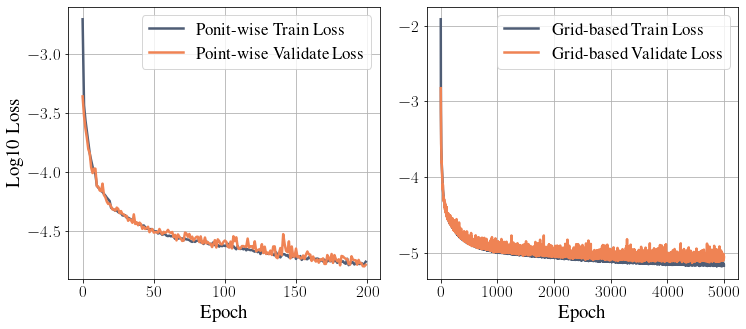

In [8]:
## Plot loss changes
fig, axes = plt.subplots( 1 , 2 , figsize=( 12 , 5 ) )
title_fontsize = 19
tick_size = 17
leg_size = 17

for i in range(2):
    
    if i == 0 :
        axes[i].plot(np.log10(np.array(model[0].train_loss)/2048), label='Ponit-wise Train Loss', linewidth=2.5, color='#4f5d75')
        axes[i].plot(np.log10(np.array(model[0].validate_loss)/2048), label='Point-wise Validate Loss', linewidth=2.5, color='#ef8354')
        axes[i].set_ylabel('Log10  Loss', fontsize=title_fontsize)
        
    if i == 1 :
        axes[i].plot(np.log10(np.array(model[1].train_loss)/(32*88)), label='Grid-based Train Loss', linewidth=2.5, color='#4f5d75')
        axes[i].plot(np.log10(np.array(model[1].validate_loss)/(32*88)), label='Grid-based Validate Loss', linewidth=2.5, color='#ef8354')
        
    axes[i].grid()
    axes[i].legend(loc='upper right', fontsize=leg_size)
    axes[i].set_xlabel('Epoch', fontsize=title_fontsize)  

    axes[i].tick_params(axis='x', labelsize=tick_size)
    axes[i].tick_params(axis='y', labelsize=tick_size)
    axes[i].yaxis.get_offset_text().set_fontsize(15) 
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()

In [9]:
# Plot relative error
with torch.no_grad():
    y_true = data_saved_gb['test'][:][1]
    y_gb = model[1](data_saved_gb['test'][:][0])

    M = grid[0]
    tau = grid[1]
    Mlb, Mub = paras_pw['M']
    tlb, tub = paras_pw['tau']
    M = (2*M.flatten() - (Mlb+Mub)) / (Mub-Mlb)
    tau = (2*tau.flatten() - (tlb+tub)) / (tub-tlb)
    M = torch.tensor(M, dtype=torch.float32).unsqueeze(1)
    tau = torch.tensor(tau, dtype=torch.float32).unsqueeze(1)

    for i in range(len(data_saved_gb['test'])):
        xx = data_saved_gb['test'][i][0]
        xx = torch.cat((xx.repeat(88, 1), M, tau), dim=1) 
        if i == 0 :
            y_pw = model[0](xx).view(1,-1)
        else :
            y_pw = torch.cat((y_pw, model[0](xx).view(1,-1)), dim=0)
        
    relative_error_pw = torch.abs((y_pw - y_true)/y_true) 
    relative_error_gb = torch.abs((y_gb - y_true)/y_true) 

    relative_error_mean_pw = np.log10(relative_error_pw.mean(dim=0).numpy().reshape(recover_y_dim))
    relative_error_mean_gb = np.log10(relative_error_gb.mean(dim=0).numpy().reshape(recover_y_dim))
    
    relative_error_median_pw = np.log10(relative_error_pw.median(dim=0)[0].numpy().reshape(recover_y_dim))
    relative_error_median_gb = np.log10(relative_error_gb.median(dim=0)[0].numpy().reshape(recover_y_dim))
    
    relative_error_std_pw = np.log10(relative_error_pw.std(dim=0).numpy().reshape(recover_y_dim))
    relative_error_std_gb = np.log10(relative_error_gb.std(dim=0).numpy().reshape(recover_y_dim))
    
heat_data_pw = [relative_error_mean_pw, relative_error_median_pw, relative_error_std_pw]
heat_data_gb = [relative_error_mean_gb, relative_error_median_gb, relative_error_std_gb]

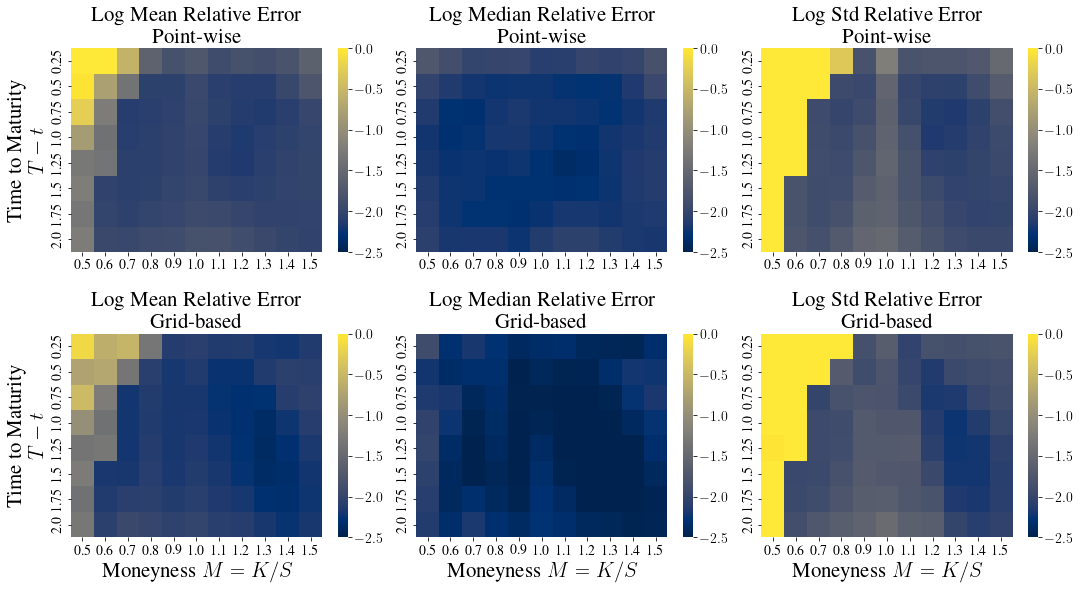

In [20]:
## Plot loss changes
fig, axes = plt.subplots( 2 , 3 , figsize=( 18, 9 ) )
title_fontsize = 21
tick_size = 14
leg_size = 17

title = [['Log Mean Relative Error\nPoint-wise', 'Log Median Relative Error\nPoint-wise', 'Log Std Relative Error\nPoint-wise'],
         ['Log Mean Relative Error\nGrid-based', 'Log Median Relative Error\nGrid-based', 'Log Std Relative Error\nGrid-based']]

for j in range(2):
    
    if j == 0:
        for i in range(3):
            hp = sns.heatmap(heat_data_pw[i], ax=axes[j,i], cmap='cividis', vmin=-2.5, vmax=0,
                        xticklabels=np.round(paras_gb['M'],1), yticklabels=np.round(paras_gb['tau'],2))
            
            colorbar = hp.collections[0].colorbar
            colorbar.ax.tick_params(labelsize=tick_size)
            
            if i == 0 :
                axes[j,i].set_ylabel('Time  to  Maturity\n $T-t$', fontsize=title_fontsize)  
                
            axes[j,i].set_title(title[j][i], fontsize=title_fontsize, fontweight='bold')
            axes[j,i].tick_params(axis='x', labelsize=tick_size)
            axes[j,i].tick_params(axis='y', labelsize=tick_size)
            axes[j,i].yaxis.get_offset_text().set_fontsize(15) 
        

    if j == 1:
        for i in range(3):
            hp = sns.heatmap(heat_data_gb[i], ax=axes[j,i], cmap='cividis', vmin=-2.5, vmax=0,
                        xticklabels=np.round(paras_gb['M'],1), yticklabels=np.round(paras_gb['tau'],2))
            
            colorbar = hp.collections[0].colorbar
            colorbar.ax.tick_params(labelsize=tick_size)

            axes[j,i].set_xlabel('Moneyness $M=K/S$', fontsize=title_fontsize)  
            
            if i == 0 :
                axes[j,i].set_ylabel('Time  to  Maturity\n$T-t$', fontsize=title_fontsize)  
                
            axes[j,i].set_title(title[j][i], fontsize=title_fontsize, fontweight='bold')
            axes[j,i].tick_params(axis='x', labelsize=tick_size)
            axes[j,i].tick_params(axis='y', labelsize=tick_size)
            axes[j,i].yaxis.get_offset_text().set_fontsize(15) 
        
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

# Calibration

In [33]:
## Calibration
data_saved_cal = Readpickle('./data/European/calibration_data_new.pkl')
theta_true = data_saved_cal['dataset'].tensors[0]
vol = data_saved_cal['dataset'].tensors[1]

Sigma , Lambda = data_saved_cal['x_norm_mat']
Lambda_inverse = torch.diag(1/Lambda.diag()).detach()

def x_transform(x):
    return torch.matmul((2 * x - Sigma), Lambda)

def x_inverse_transform(x):
    return (torch.matmul(x, Lambda_inverse) + Sigma)/2


# data_saved_cal['x_norm_mat']
# # theta_true_origin = inverse_transformX(theta_true.detach().numpy(), data_saved_cal['paras'], data_saved_cal['para_index'])

In [51]:
def f_gb(theta, yy):
    
    theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
    theta = torch.cat((torch.tensor([-1/6]), theta))
    
    with torch.no_grad():
        y_gb = model[1](theta)
    return (y_gb - yy).detach().numpy()


def Joc_gb(theta, yy):
    
    theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
    theta = torch.cat((torch.tensor([-1/6]), theta)).requires_grad_(True)
    
    yy = yy.requires_grad_(True)
    J = torch.autograd.grad((model[1](theta) - yy)[0], theta, create_graph=True)[0].unsqueeze(0)
    for i in range(1,len(yy)):
        grad = torch.autograd.grad((model[1](theta) - yy)[i], theta, create_graph=True)[0].unsqueeze(0)
        J = torch.cat((J,grad),dim=0)

    return J.detach().numpy()[:,1:]

In [64]:
# Grid-based
from scipy.optimize import least_squares
theta_hat = []
for i in tqdm(range(len(theta_true))) :
    yy = vol[i]
    theta_temp = least_squares(lambda theta: f_gb(theta, yy), x0=np.array([0,0,0,0,0]), 
                          jac= lambda theta: Joc_gb(theta, yy),
                          method='lm',gtol=1E-10).x
    theta_temp = np.insert(theta_temp, 0, -1/6)
    theta_hat.append(theta_temp)
    
theta_hat = torch.tensor(np.array(theta_hat), dtype=torch.float32)
Savepickle(theta_hat, doc_path='./data/European/calibration_result_theta_gb_new.pkl')

  0%|          | 0/5000 [00:00<?, ?it/s]

## Analysis

In [115]:
theta_hat = Readpickle('./data/European/calibration_result_theta_gb_new.pkl')[:1500]
theta_true = data_saved_cal['dataset'].tensors[0][:1500]
relative_error_gb = np.log(torch.abs((theta_hat - theta_true)/theta_true).detach().numpy())
mean_re = relative_error_gb.mean(axis=0)
median_re = np.median(relative_error_gb, axis=0)

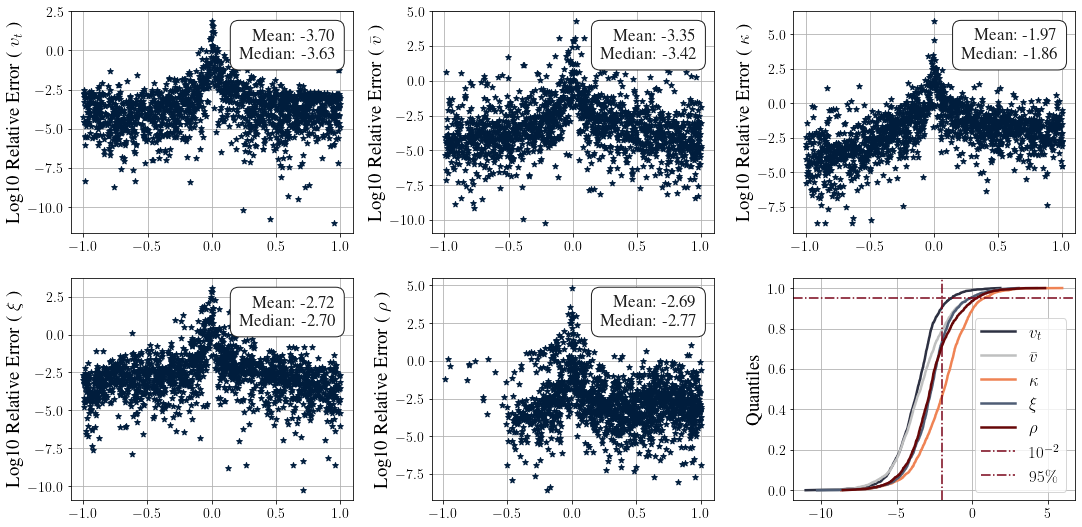

In [139]:
## Plot grid-based calibration result
fig, axes = plt.subplots( 2 , 3 , figsize=( 18, 9 ) )
title_fontsize = 19
tick_size = 14
leg_size = 17
colors = ['#2d3142','#bfc0c0','#ef8354','#4f5d75','#660708']
lab = ['$v_t$', '$\\bar{v}$', '$\\kappa$', '$\\xi$', '$\\rho$']

for i in range(2):
    for j in range(3):
        k = i * 3 + j 
        if k <= 4 :
            axes[i,j].scatter(theta_true[:, k+1], relative_error_gb[:, k+1], 
                              marker='*', color='#001d3d')
            axes[i,j].set_ylabel('Log10 Relative Error ( %s )'%(lab[k]), fontsize=title_fontsize)
            axes[i,j].text(0.94, 0.92, 'Mean: %.2f\nMedian: %.2f'%(mean_re[k+1], median_re[k+1]), horizontalalignment='right', 
                           verticalalignment='top', transform=axes[i,j].transAxes, fontsize=17, color='#202020',
                        bbox=dict(facecolor='white', edgecolor='#202020', boxstyle='round,pad=0.5')) 
            
        if k ==5 :
            for t in range(1,6):
                data = relative_error_gb[:, t]
                sorted_data = np.sort(data)
                yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
                axes[i,j].plot(sorted_data, yvals, label=lab[t-1], color=colors[t-1], linewidth=2.5)
                axes[i,j].set_ylabel('Quantiles', fontsize=title_fontsize) 
            axes[i,j].axvline(x=-2, color='#780116', linestyle='-.', label='$10^{-2}$')
            axes[i,j].axhline(y=0.95, color='#780116', linestyle='-.', label='$95\%$')
            axes[i,j].legend(loc='lower right', fontsize=leg_size)
        
        axes[i,j].grid(True)
        axes[i,j].set_axisbelow(True)

        axes[i,j].tick_params(axis='x', labelsize=tick_size)
        axes[i,j].tick_params(axis='y', labelsize=tick_size)
        axes[i,j].yaxis.get_offset_text().set_fontsize(15) 
        
        
plt.subplots_adjust(wspace=0.28, hspace=0.2)
plt.show()
            

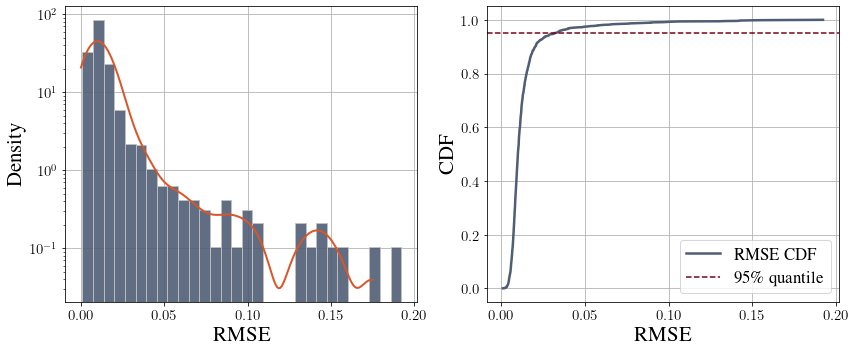

In [117]:
MSE = (((model[1](theta_hat)-model[1](theta_true))**2).sum(dim=1))
rmse = np.sqrt(MSE.detach().numpy())
title_fontsize = 21
tick_size = 15
leg_size = 17


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(rmse, bins=30, density=True, log=True, alpha=0.9, color='#4f5d75', edgecolor='#bfc0c0')
sns.kdeplot(rmse, ax=axs[0], color='#d8572a', linewidth=2, bw_adjust=2, clip=(0, 0.175))

axs[0].set_xlabel('RMSE', fontsize=title_fontsize)
axs[0].set_ylabel('Density', fontsize=title_fontsize)

sorted_data = np.sort(rmse)
cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
axs[1].plot(sorted_data, cdf, color='#4f5d75', label='RMSE CDF', linewidth=2.5)
axs[1].axhline(y=0.95, color='#780116', linestyle='--', label='95\% quantile')
axs[1].legend(loc='lower right', fontsize=leg_size)

axs[1].set_xlabel('RMSE', fontsize=title_fontsize)
axs[1].set_ylabel('CDF', fontsize=title_fontsize)

for i in range(2):
    axs[i].grid(True)
    axs[i].set_axisbelow(True)
    axs[i].tick_params(axis='x', labelsize=tick_size)
    axs[i].tick_params(axis='y', labelsize=tick_size)

plt.tight_layout()
plt.show()